# Part B: Analysing CSV Data

<font size = "3">It has eight parts of this task, and they are including the import pyspark, initialize Spark, create dataframe, write to mongodb database, calculating the statistics of numeric and string column, changing the data type, data analysis and visulize the data.</font>

## Step 01: Import pyspark and initialize Spark

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 
    
# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]")
crime_spark = SparkSession(sparkContext=sc)\
    .builder \
    .appName("Analysing_Criminal_Data") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/criminal_db.analysing") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/criminal_db.analysing") \
    .getOrCreate()

## Step 02: Create Dataframe

In [2]:
# Create Dataframe and display how many records are there in the dataframe

crime_df = crime_spark.read.csv('Crime_Statistics_SA_2010_present.csv', header=True, inferSchema=True) #creating the dataframe
print("It has {0} records in the dataframe".format(crime_df.count())) #showing the records in the data frame

It has 727408 records in the dataframe


In [3]:
nonNullCrimedf = crime_df.na.drop() #drop the null value in the data frame
print("It has {0} rows in the data frame which exclude the null value data".format(nonNullCrimedf.count())) #count how many number of rows in the data frame
nonNullCrimedf.take(10) #show the first ten rows data

It has 726921 rows in the data frame which exclude the null value data


[Row(Reported Date='1/07/2010', Suburb - Incident='ADELAIDE', Postcode - Incident='5000', Offence Level 1 Description='OFFENCES AGAINST PROPERTY', Offence Level 2 Description='FRAUD DECEPTION AND RELATED OFFENCES', Offence Level 3 Description='Obtain benefit by deception', Offence Count=2),
 Row(Reported Date='1/07/2010', Suburb - Incident='ADELAIDE', Postcode - Incident='5000', Offence Level 1 Description='OFFENCES AGAINST PROPERTY', Offence Level 2 Description='PROPERTY DAMAGE AND ENVIRONMENTAL', Offence Level 3 Description='Other property damage and environmental', Offence Count=2),
 Row(Reported Date='1/07/2010', Suburb - Incident='ADELAIDE', Postcode - Incident='5000', Offence Level 1 Description='OFFENCES AGAINST PROPERTY', Offence Level 2 Description='SERIOUS CRIMINAL TRESPASS', Offence Level 3 Description='SCT - Non Residence', Offence Count=1),
 Row(Reported Date='1/07/2010', Suburb - Incident='ADELAIDE', Postcode - Incident='5000', Offence Level 1 Description='OFFENCES AGAINS

## Step 03: Write to Database

In [4]:
#Write the data into the Database (Mongodb)
nonNullCrimedf.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()

## Step 04: Read from Database

In [5]:
#Read from Database
crime_df_mongodb = crime_spark.read.format("com.mongodb.spark.sql.DefaultSource").load() #read the data from database
crime_df_mongodb.show(20, False) #show the top 20 rows data in the dataframe
crime_df_mongodb.printSchema() #show the schema in the dataframe

+-------------+---------------------------+------------------------------------+---------------------------------------+-------------------+-------------+-----------------+--------------------------+
|Offence Count|Offence Level 1 Description|Offence Level 2 Description         |Offence Level 3 Description            |Postcode - Incident|Reported Date|Suburb - Incident|_id                       |
+-------------+---------------------------+------------------------------------+---------------------------------------+-------------------+-------------+-----------------+--------------------------+
|2            |OFFENCES AGAINST PROPERTY  |FRAUD DECEPTION AND RELATED OFFENCES|Obtain benefit by deception            |5000               |1/07/2010    |ADELAIDE         |[5d71d7733a10c20c5ef44b86]|
|2            |OFFENCES AGAINST PROPERTY  |PROPERTY DAMAGE AND ENVIRONMENTAL   |Other property damage and environmental|5000               |1/07/2010    |ADELAIDE         |[5d71d7733a10c20c5ef44b87]|


<font size = "3">According to the schema information, it shows that the data type of reported date is the string data type which is not the correct data type for date information. Therefore, it will show the incorrect ranking of max and min date value information so it will change the data type of reported date from string to date on the further step.</font>

## Step 05: Calculate the statistics of numeric and string columns

In [6]:
# Using the describe function to calculate the statistic data in the numeric column (offence count) and string colums (reported date)
crime_df_mongodb.describe("Offence Count", "Reported Date").show()

+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            726921|       726921|
|   mean| 1.171599114621809|         null|
| stddev|0.5788485264995505|         null|
|    min|                 1|    1/01/2011|
|    max|                28|    9/12/2018|
+-------+------------------+-------------+



<font size = "3">According this result, it shows the maximum value of **"Offence Count"** is 28 but the **"Reported Date" (08/12/2018)** is not the correct value, which the correct one is 31/03/2019. Also, the result of minimum value of **"Offence Count"** is 1 but the **"Reported Date" (01/01/2011)** is not the correct answer, which the correct one is 01/07/2010.

The reason of calculating wrong result of maximum and minimum value on **"Reported Date"** is caused by inappropriate data type. The inaccurate data type of **"Reported Date"** is string which the correct data type should be date format. Therefore, it might be the reason for getting the incorrect result of **"Reported Date"** when the data type is string then it will return the result based on ASCII. Meanwhile, it cannot retrieve correct maximum and mimimum value on **"Reported Date"** column based on the incorrect data type.</font>

In [7]:
# Show the maximum value of "Offence Count" and "Reported Date" two columns

# groupBy("Reported Date") : grouping the reported date first because it has different records of offence count at the same date
# agg({"Offence Count": "max"}) : calculating the maximum value of offence count
# withColumnRenamed("max(Offence Count)", "Offence Count") : rename the column name
# sort("Offence Count", ascending=False) : using the descending order to show the maximum value on the top rows of Offence Count column

crime_df_mongodb.groupBy("Reported Date")\
                .agg({"Offence Count": "max"})\
                .withColumnRenamed("max(Offence Count)", "Offence Count")\
                .sort("Offence Count", ascending=False)\
                .show() #showing the result

+-------------+-------------+
|Reported Date|Offence Count|
+-------------+-------------+
|   28/09/2016|           28|
|   12/12/2018|           27|
|   23/05/2012|           25|
|   30/06/2013|           23|
|    2/12/2016|           18|
|   22/11/2018|           17|
|   12/10/2011|           17|
|   16/02/2011|           17|
|   29/03/2012|           16|
|   20/09/2013|           16|
|   25/08/2016|           16|
|   13/08/2010|           16|
|    8/04/2015|           15|
|   15/03/2011|           15|
|   28/03/2012|           15|
|   26/04/2016|           14|
|    8/09/2013|           14|
|   12/06/2011|           14|
|   15/12/2013|           14|
|   19/02/2019|           13|
+-------------+-------------+
only showing top 20 rows



<font size = "3"> If it want to retrieve the corresponding result of maximum value on **"Reported Date"** based on **"Offence Count"** column. Then, it can use the **"groupBy"** and **"aggregate"** methods to achieve this task.</font>

In [8]:
# Show the minimum value of "Offence Count" and "Reported Date" two columns

# groupBy("Reported Date") : grouping the reported date first because it has different records of offence count at the same date
# agg({"Offence Count": "min"}) : calculating the minimum value of offence count
# withColumnRenamed("min(Offence Count)", "Offence Count") : rename the column name
# sort("Reported Date", ascending=False) : using the descending order to show the maximum value at the top row of Reported Date column

crime_df_mongodb.groupBy("Reported Date")\
                .agg({"Offence Count": "min"})\
                .withColumnRenamed("min(Offence Count)", "Offence Count")\
                .sort("Reported Date", ascending = False)\
                .show() #showing the result

+-------------+-------------+
|Reported Date|Offence Count|
+-------------+-------------+
|    9/12/2018|            1|
|    9/12/2016|            1|
|    9/12/2015|            1|
|    9/12/2014|            1|
|    9/12/2013|            1|
|    9/12/2012|            1|
|    9/12/2011|            1|
|    9/12/2010|            1|
|    9/11/2018|            1|
|    9/11/2016|            1|
|    9/11/2015|            1|
|    9/11/2014|            1|
|    9/11/2013|            1|
|    9/11/2012|            1|
|    9/11/2011|            1|
|    9/11/2010|            1|
|    9/10/2018|            1|
|    9/10/2016|            1|
|    9/10/2015|            1|
|    9/10/2014|            1|
+-------------+-------------+
only showing top 20 rows



In [9]:
# Count the number of minimum value on the column
countMinColumn = crime_df_mongodb.groupBy("Reported Date").agg({"Offence Count": "min"}).count()
print(countMinColumn)

2831


<font size = "3">It shows the corresponding result of **"Reported Date"** based on the minimum value of **"Offence Count"**. However, it has numerous minimum value, which is 1, on the **"Offence Count"** column. The number of minimum value has including 2832 records, but even if it uses the **"sort"** method to get the descending order by **"Reported Date"**. Then, it also cannot retrieve the correct order by **"Reported Date"** either because the reason might be the data type is string which is using ASCII to calculate the result of maximum and minimum value on **"Reported Date"**.</font>

## Step 06: Change the data type of a column

In [10]:
# Import the to_date function from pyspark.sql.functins to convert string to date type
# Import the udf function from pyspark.sql.functins to use the user defined functions
from pyspark.sql.functions import to_date
from pyspark.sql.functions import udf

In [11]:
# Define the function to convert the data type from string to date
def convertdatefunc (dataframe, data): #convertdatefunc has two parameters, one is dataframe and the other one is data which is the converting column
    return dataframe.withColumn("Modify Reported Date", to_date(data, "dd/MM/yyyy")) #adding a column to record the modifying data

In [12]:
# Define the user-defined fucntions
dateconvert = udf(convertdatefunc) #to call the convertdatefunc into the user defined functions

In [13]:
# Updating the column within the new dataframe in the mongodb
newDatetype_crime_df_mongodb = convertdatefunc(crime_df_mongodb, "Reported Date") #to call the user defined function within the convertdatefunc with two parameters

In [14]:
# Print the schema with new column of Modify Reported Date to check the data type of date in the dataframe
newDatetype_crime_df_mongodb.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- Modify Reported Date: date (nullable = true)



<font size = "3">The schema shows that the data type of **"Modify Reported Date"** column is date format which is changing the data type from string data type on **"Reported Date"** column to date data type on **"Modify Reported Date"** column.</font>

In [15]:
# Display the first twenty rows in the data frame on "Modify Reported Date" column
newDatetype_crime_df_mongodb.select("Modify Reported Date").take(20)

[Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=datetime.date(2010, 7, 1)),
 Row(Modify Reported Date=da

## Step 07: Preliminary data analysis

### 1. How many level 2 offences are there?

In [16]:
# Display the number of each description on the level 2 offence
newDatetype_crime_df_mongodb.groupBy("Offence Level 2 Description").count().show(9, False)

+------------------------------------+------+
|Offence Level 2 Description         |count |
+------------------------------------+------+
|ROBBERY AND RELATED OFFENCES        |5843  |
|PROPERTY DAMAGE AND ENVIRONMENTAL   |166100|
|SEXUAL ASSAULT AND RELATED OFFENCES |13367 |
|HOMICIDE AND RELATED OFFENCES       |441   |
|ACTS INTENDED TO CAUSE INJURY       |112866|
|SERIOUS CRIMINAL TRESPASS           |104903|
|OTHER OFFENCES AGAINST THE PERSON   |23392 |
|FRAUD DECEPTION AND RELATED OFFENCES|19563 |
|THEFT AND RELATED OFFENCES          |280446|
+------------------------------------+------+



In [17]:
print("It has {0} total rows on the Offence Level 2 Description column".format(newDatetype_crime_df_mongodb.select("Offence Level 2 Description").count()))

It has 726921 total rows on the Offence Level 2 Description column


<font size = "3">It shows the different description type of level 2 offence and also the number is counted by each type of description. The total types of **"Offence Level 2 Description"** have 9 types, and the number of total rows have 726921 data point. Each of these types are **"ROBBERY AND RELATED OFFENCES"** has 5843 rows,  **"PROPERTY DAMAGE AND ENVIRONMENTAL"** has 166100 rows, **"SEXUAL ASSAULT AND RELATED OFFENCES"** has 13367 rows, **"HOMICIDE AND RELATED OFFENCES"** has 441 rows, **"ACTS INTENDED TO CAUSE INJURY"** has 112866 rows, **"SERIOUS CRIMINAL TRESPASS"** has 104903 rows, **"OTHER OFFENCES AGAINST THE PERSON"** has 23392 rows, **"FRAUD DECEPTION AND RELATED OFFENCES"** has 19563 rows, **"THEFT AND RELATED OFFENCES"** has 280446 rows.
In addition, the top one crimes event is  **"THEFT AND RELATED OFFENCES"**, and the less one crimes event is  **"HOMICIDE AND RELATED OFFENCES"** can be found in the above table.</font>

### 2. What is the number of offences against the person?

In [18]:
newDatetype_crime_df_mongodb.groupBy("Offence Level 1 Description").count().show(2, False) #to show the number of offecnces against the person

+---------------------------+------+
|Offence Level 1 Description|count |
+---------------------------+------+
|OFFENCES AGAINST THE PERSON|155909|
|OFFENCES AGAINST PROPERTY  |571012|
+---------------------------+------+



<font size = "3">It has 155909 records to demenstrate the number of offences against the person.</font>

### 3. How many serious criminal tresspasses with more than 1 offence count?

In [19]:
# Calculating the number of serious criminal tresspasses with more than 1 offence count
numSeriousgt1 = newDatetype_crime_df_mongodb.select("Offence Count", "Offence Level 2 Description")\
.filter(newDatetype_crime_df_mongodb["Offence Level 2 Description"] == "SERIOUS CRIMINAL TRESPASS")\
.filter(newDatetype_crime_df_mongodb["Offence Count"] > 1).count()

In [20]:
print("It has {0} serious criminal tresspasses with more than 1 offence count.".format(numSeriousgt1))

It has 8574 serious criminal tresspasses with more than 1 offence count.


### 4.What percentage of crimes are offences against the property?

In [21]:
# Calculating the percentage of crimes are offences against the property
totalOffence = newDatetype_crime_df_mongodb.select("Offence Level 1 Description").count() #count the total number of offence
subsetOffence = newDatetype_crime_df_mongodb.select("Offence Level 1 Description")\
.filter(newDatetype_crime_df_mongodb["Offence Level 1 Description"] == "OFFENCES AGAINST PROPERTY")\
.count() #count the number of "OFFENCES AGAINST PROPERTY"

# Create the function to calculate the percentage which is the subset divided by original data set
def percentage(total, subset):
    percent = round((subset / total) * 100, 2)
    return str(percent) + str("%")

In [22]:
print("It has {0} percent of crimes are offences against the property.".format(percentage(totalOffence, subsetOffence)))

It has 78.55% percent of crimes are offences against the property.


## Step 08: Exploratory data analysis

In [23]:
from pyspark.sql.functions import year, month #for extracting the year and month data from Modify Reported Date column
import matplotlib.pyplot as plt #import the matplotlib
import numpy as np #import numpy

### 1. Plot the graph of the number of crimes per year

<font size = "3">The reason of choosing the line graph to demonstrate the crimes data because it is very transparent way to see the trend of the number of crimes, which the number of crimes are increasing or decreasing in the particular year.</font>

In [24]:
# Preparing data for plotting line chart to demonstrate the trend of the number of crimes
# Split the Modify Reported Date by year
# withColumnRenamed("year(Modify Reported Date)", "Year") : rename the column
# sort("Year") : sorting the year data
YearDF = newDatetype_crime_df_mongodb.select(year("Modify Reported Date"), "Offence Count")\
                .withColumnRenamed("year(Modify Reported Date)", "Year")\
                .sort("Year")

In [25]:
# Groupby the data by year then counting the offence number at each particular year
crimesYearDF = YearDF.groupBy("Year").sum("Offence Count").withColumnRenamed("sum(Offence Count)", "Count")
crimesYearDF.show(20)

+----+------+
|Year| Count|
+----+------+
|2010| 61382|
|2011|122176|
|2012|112953|
|2013|106761|
|2014|101727|
|2015|105628|
|2016|107566|
|2017| 50144|
|2018| 55570|
|2019| 27753|
+----+------+



In [26]:
# Plotting the line graph
crimesYearList = crimesYearDF.collect() #convert dataframe to list
yearX = [row["Year"] for row in crimesYearList] #x axis for the number of crimes
crimesY = [row["Count"] for row in crimesYearList] #y axif for each year

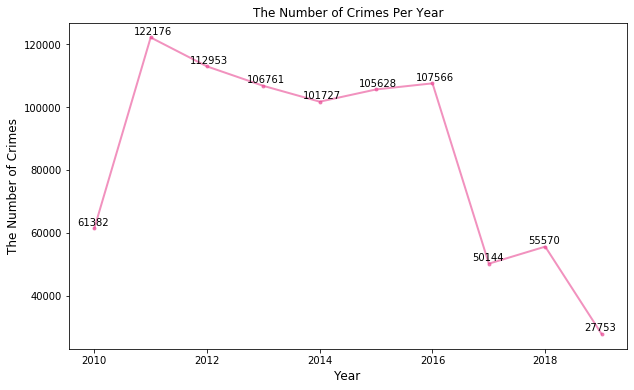

In [27]:
# Plotting the line graph
plt.figure(figsize = (10,6)) #setting the size of figure
plt.plot(yearX, crimesY, ".-", color = "#E94994", linewidth = 2, alpha = 0.6) #plotting the line chart and setting the color
plt.xlabel("Year", fontsize = 12) #giving the specifice name on the x axis
plt.ylabel("The Number of Crimes", fontsize = 12) #giving the specifice name on the y axis
plt.title("The Number of Crimes Per Year") #giving the specifice name on the title of this graph
for x, y in zip(yearX , crimesY): #showing the each point of data on the graph
    plt.text(x-0.3, y+1000, "%.0f" %y)
plt.show() #displaying the graph

<font size = "3">From the 2010 to 2011, the number of crimes have sharply increasing from 61382 to 122176. The reason might have this significant changed because it has only contained six months in 2010 which it does not the entire year data, aslo it has the same situation in 2019. The crimes number of each year has slight changed since 2011 to 2014 which the crimes events decrease between these four years, and then smoothly increase from 101727 to 107566 between 2014 and 2016. After 2016, the number of crimes roar dip suddenly in 2017 which has decreased by 50144. During 2017 to 2019 year, it has not big changed from 2017 to 2018, but the number of crimes have the significant declined since 2018. The reason can be the crimes data does not contain the entire year in 2019 which it only has three months in this year. Therefore, according to this graph and the data, it only can draw a simple conclusion on it, which it has higher crimes happening between 2011 and 2016 year, then it suddenly declines from 2016 to 2018 year because it has the incomplete information during 2017 and 2018. The peak of the number of crimes is 122176 in 2011, but it is hard to draw the conclusion on the lower point becuase it doesn't have the same standard criteria to compare the complete and incomplete the data information which means they are different data records to record the crimes information during the entire year or partial month in the year.</font>

### 2. Plot the graph of the number of crimes per month

<font size = "3">The reason of choosing the line graph to demonstrate the crimes data because it is very transparent way to see the trend of crimes number, which the trend is increasing or decreasing in the particular month.</font>

In [28]:
monthDF = newDatetype_crime_df_mongodb.select(month("Modify Reported Date"), "Offence Count")\
                .withColumnRenamed("month(Modify Reported Date)", "Month")\
                .sort("Month")

In [29]:
#groupby the data at each specific year
crimesMonthDF = monthDF.groupBy("Month").sum("Offence Count").withColumnRenamed("sum(Offence Count)", "Count")
crimesMonthDF.show()

+-----+-----+
|Month|Count|
+-----+-----+
|    1|77434|
|    2|70373|
|    3|74876|
|    4|60027|
|    5|64231|
|    6|60678|
|    7|70907|
|    8|72799|
|    9|72552|
|   10|77119|
|   11|75129|
|   12|75535|
+-----+-----+



In [30]:
# Plotting the line graph
crimesMonthList = crimesMonthDF.collect() #convert dataframe to list
monthX = [row["Month"] for row in crimesMonthList] #x axis for the number of crimes
crimesMonthY = [row["Count"] for row in crimesMonthList] #y axif for each year

In [31]:
# Count the average crime events by month
totalCrimes = crimesMonthDF.groupBy().sum("Count").show() #count the total crimes number
aveCrimes = int(851660 / 12) #average crimes number per month
print("The average number of crimes is {0}".format(aveCrimes))

+----------+
|sum(Count)|
+----------+
|    851660|
+----------+

The average number of crimes is 70971


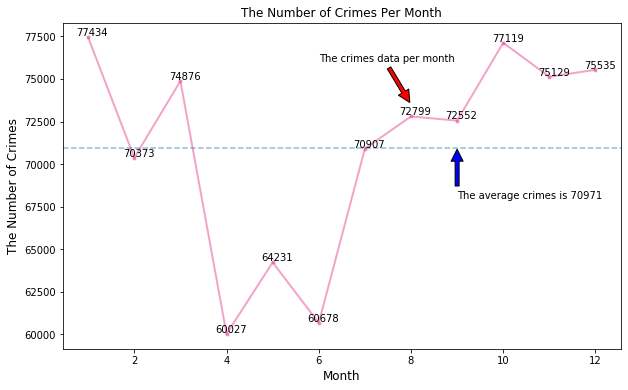

In [32]:
# Plotting the line graph
plt.figure(figsize = (10,6)) #setting the size of figure
plt.plot(monthX, crimesMonthY, ".-", color = "#E94994", linewidth = 2, alpha = 0.5) #plotting the line chart and setting the color
plt.xlabel("Month", fontsize = 12) #giving the specifice name on the x axis
plt.ylabel("The Number of Crimes", fontsize = 12) #giving the specifice name on the y axis
plt.title("The Number of Crimes Per Month") #giving the specifice name on the title of this graph
plt.axhline(aveCrimes, linestyle = "dashed", linewidth = 1.5, alpha = 0.5) #the crimes average line between 1 to 12 months
for x, y in zip(monthX , crimesMonthY): #showing the each point of data on the graph
    plt.text(x-0.25, y+100, "%.0f" %y)
#plt.text(9, 59000, r"The average crimes is 60576")
plt.annotate("The crimes data per month", xy = (8, 73500), xytext = (6, 76000),
             arrowprops = dict(facecolor = "red", shrink = 0.05)) #providing the text information for average crimes line
plt.annotate("The average crimes is 70971", xy = (9, 71000), xytext = (9, 68000),
             arrowprops = dict(facecolor = "blue", shrink = 0.05)) #providing the text information for average crimes line
plt.show() #displaying the graph

<font size = "3">According to the line graph as showing on above, it has less remarkable changed than crimes data by year. The average of crimes number is 70971, and it has around five months under this average crimes point which are February, April, May, June, and July. The lower point crimes month is April which has 60027 crimes events during this month, and the peak point of crimes event is 77434 in January from 2010 to 2019. In conclusion, the crimes events might be happening a lot during the season in summer, on the opposite, it might have less crimes events in winter than other seasons. </font>

### 3. Where do most crimes take place? Find the top 20 suburbs and plot it

In [33]:
#import the concat, lit and col functions to do the merge column
from pyspark.sql.functions import concat, lit, col

In [34]:
# Merge the two different colums, one is Suburb - Incident, another is Postcode - Incident
# withColumnRenamed("concat(Suburb - Incident, -, Postcode - Incident)", "Suburb") : rename the column name
mergeDF = newDatetype_crime_df_mongodb.select("Suburb - Incident", "Offence Count",
                                              concat (col("Suburb - Incident"), lit("-"), 
                                                      col("Postcode - Incident")))\
            .withColumnRenamed("concat(Suburb - Incident, -, Postcode - Incident)", "Suburb")

In [35]:
# Show the number cirmes of top 20 suburb
mergeDF.groupBy("Suburb").agg({"Offence Count" : "count"})\
.sort("count(Offence Count)", ascending = False)\
.withColumnRenamed("count(Offence Count)", "Count")\
.show(20, False)

+---------------------------+-----+
|Suburb                     |Count|
+---------------------------+-----+
|ADELAIDE-5000              |21684|
|MOUNT GAMBIER-5290         |10000|
|PORT AUGUSTA-5700          |9619 |
|MORPHETT VALE-5162         |9548 |
|MURRAY BRIDGE-5253         |9423 |
|NOT DISCLOSED-NOT DISCLOSED|8939 |
|SALISBURY-5108             |8332 |
|PORT LINCOLN-5606          |7848 |
|ELIZABETH-5112             |7686 |
|PARAFIELD GARDENS-5107     |6640 |
|DAVOREN PARK-5113          |6519 |
|PARALOWIE-5108             |6084 |
|PROSPECT-5082              |5927 |
|PORT PIRIE-5540            |5772 |
|OAKLANDS PARK-5046         |5668 |
|MODBURY-5092               |5537 |
|SALISBURY NORTH-5108       |5492 |
|SMITHFIELD-5114            |5412 |
|WHYALLA STUART-5608        |5106 |
|MAWSON LAKES-5095          |4863 |
+---------------------------+-----+
only showing top 20 rows



In [36]:
# Convert the dataframe to list
mergeList = mergeDF.groupBy("Suburb").agg({"Offence Count" : "count"})\
            .sort("count(Offence Count)", ascending = False)\
            .withColumnRenamed("count(Offence Count)", "Count")\
            .take(20)

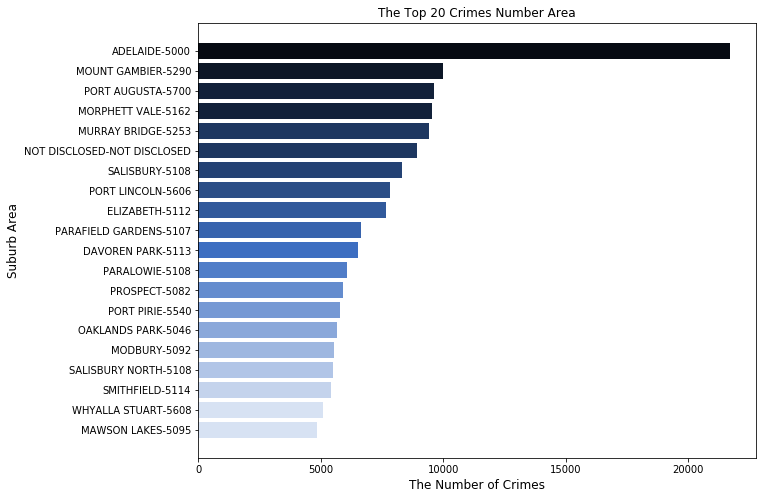

In [37]:
# Plotting the bar chart
crimesSubY = [row["Count"] for row in mergeList] #x axis for the number of crimes
suburbX = [row["Suburb"] for row in mergeList] #y axif for the name of suburb
suburbLenX = np.arange(len(suburbX))
crimesSubLenY = np.arange(len(crimesSubY))

plt.figure(figsize = (10,8)) #setting the figure size

colorMap = ["#060A12", "#0C1626", "#12213A", "#12213A", "#1E3760", "#1E3760", "#244274", "#2B4E87", "#31599B", 
            "#3763AD", "#3D6EC1", "#507DC8", 
            "#648CCE", "#7699D4", "#8AA8DA", "#9EB7E0", "#B1C5E7", "#C4D3EC", "#D7E2F3", "#D7E2F3"] #creating the color map for bar chart

plt.barh(suburbX, crimesSubY, align='center', color=colorMap) #creating the horizontal bar chart
plt.xlabel("The Number of Crimes", fontsize = 12) #creating the label on x axis
plt.ylabel("Suburb Area", fontsize = 12) #creating the the label on y axis
plt.title("The Top 20 Crimes Number Area") #creating the title name on the graph

plt.gca().invert_yaxis()

<font size = "3"> The reason to use bar chart to show the result of top 20 crimes area in Australia, because it is easy to realize the ranking data from the bar chart. According to this bar chart shows on above, the suburb area which is **"ADELAIDE"** and the postcode is 5000 has the extremely crimes events happened in here which the number is exceeding 20000 from 2010 to 2019. The other areas, which are **"MOUNT GAMBIER-5290"**, **"PORT AUGUSTA-5700"**, **"MORPHETT VALE-5162"**, and **"MURRAY BRIDGE-5253"**, have around 10000 crimes events during this ten years. The rest of areas have less than 10000 crimes events since 2010.</font>

### 4. Plot the number of serious criminal trespasses by day and month

In [38]:
# Import the function from pyspark sql
from pyspark.sql.functions import date_format, when

In [39]:
# Converting the date information to day and 
dayMonthDF = newDatetype_crime_df_mongodb.select("Modify Reported Date", "Offence Level 2 Description", month("Modify Reported Date"),
                                                date_format("Modify Reported Date", "E").alias("Day"))\
                                            .withColumnRenamed("month(Modify Reported Date)", "Month")
dayMonthDF.show(20, False)

+--------------------+------------------------------------+-----+---+
|Modify Reported Date|Offence Level 2 Description         |Month|Day|
+--------------------+------------------------------------+-----+---+
|2010-07-01          |FRAUD DECEPTION AND RELATED OFFENCES|7    |Thu|
|2010-07-01          |PROPERTY DAMAGE AND ENVIRONMENTAL   |7    |Thu|
|2010-07-01          |SERIOUS CRIMINAL TRESPASS           |7    |Thu|
|2010-07-01          |THEFT AND RELATED OFFENCES          |7    |Thu|
|2010-07-01          |THEFT AND RELATED OFFENCES          |7    |Thu|
|2010-07-01          |ACTS INTENDED TO CAUSE INJURY       |7    |Thu|
|2010-07-01          |PROPERTY DAMAGE AND ENVIRONMENTAL   |7    |Thu|
|2010-07-01          |THEFT AND RELATED OFFENCES          |7    |Thu|
|2010-07-01          |THEFT AND RELATED OFFENCES          |7    |Thu|
|2010-07-01          |PROPERTY DAMAGE AND ENVIRONMENTAL   |7    |Thu|
|2010-07-01          |ACTS INTENDED TO CAUSE INJURY       |7    |Thu|
|2010-07-01         

In [40]:
# Create the new column for Months
# when(col("Month") == 1, "Jan") : it means if Month column has value 1 then it will show on the new column with Jan
monthColumn = when(col("Month") == 1, "Jan").when(col("Month") == 2, "Feb")\
                .when(col("Month") == 3, "Mar").when(col("Month") == 4, "Apr")\
                .when(col("Month") == 5, "May").when(col("Month") == 6, "Jun")\
                .when(col("Month") == 7, "Jul").when(col("Month") == 8, "Aug")\
                .when(col("Month") == 9, "Sep").when(col("Month") == 10, "Oct")\
                .when(col("Month") == 11, "Nov").when(col("Month") == 12, "Dec")

In [41]:
# Create the new column for days to sort the day by order using the numerical value
dayColumn = when(col("Day") == "Mon", 1).when(col("Day") == "Tue", 2)\
                .when(col("Day") == "Wed", 3).when(col("Day") == "Thu", 4)\
                .when(col("Day") == "Fri", 5).when(col("Day") == "Sat", 6)\
                .when(col("Day") == "Sun", 7)\

In [42]:
# Create the new column in the dayMonthDF (dataframe)
newDayMonthDF = dayMonthDF.withColumn("Months", monthColumn).withColumn("Days",dayColumn)
newDayMonthDF.show(20, False)

+--------------------+------------------------------------+-----+---+------+----+
|Modify Reported Date|Offence Level 2 Description         |Month|Day|Months|Days|
+--------------------+------------------------------------+-----+---+------+----+
|2010-07-01          |FRAUD DECEPTION AND RELATED OFFENCES|7    |Thu|Jul   |4   |
|2010-07-01          |PROPERTY DAMAGE AND ENVIRONMENTAL   |7    |Thu|Jul   |4   |
|2010-07-01          |SERIOUS CRIMINAL TRESPASS           |7    |Thu|Jul   |4   |
|2010-07-01          |THEFT AND RELATED OFFENCES          |7    |Thu|Jul   |4   |
|2010-07-01          |THEFT AND RELATED OFFENCES          |7    |Thu|Jul   |4   |
|2010-07-01          |ACTS INTENDED TO CAUSE INJURY       |7    |Thu|Jul   |4   |
|2010-07-01          |PROPERTY DAMAGE AND ENVIRONMENTAL   |7    |Thu|Jul   |4   |
|2010-07-01          |THEFT AND RELATED OFFENCES          |7    |Thu|Jul   |4   |
|2010-07-01          |THEFT AND RELATED OFFENCES          |7    |Thu|Jul   |4   |
|2010-07-01     

In [43]:
# Filtered the crimes type of SERIOUS CRIMINAL TRESPASS in the dataframe 
filteredDF = newDayMonthDF.select("Offence Level 2 Description","Days", "Day", "Months", "Month")\
                .filter(newDayMonthDF["Offence Level 2 Description"] == "SERIOUS CRIMINAL TRESPASS")
filteredDF.show(20, False)

+---------------------------+----+---+------+-----+
|Offence Level 2 Description|Days|Day|Months|Month|
+---------------------------+----+---+------+-----+
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRIMINAL TRESPASS  |5   |Fri|Jul   |7    |
|SERIOUS CRI

In [44]:
# Groupby day and months to calculate the number of SERIOUS CRIMINAL TRESPASS
dayDF = filteredDF.groupBy("Days", "Day").count().sort("Days")
monthDF = filteredDF.groupBy("Months", "Month").count().sort("Month")

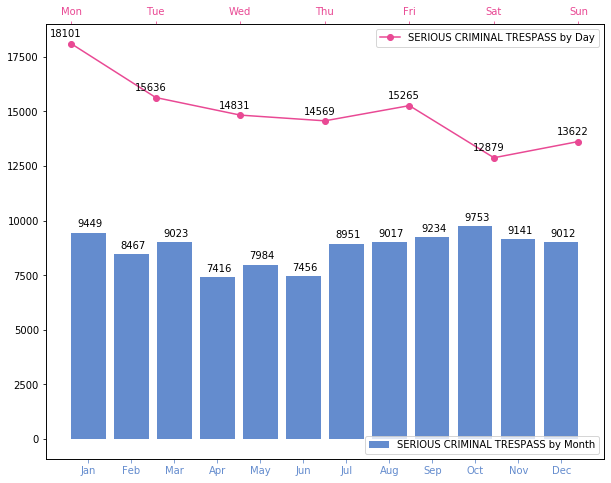

In [45]:
# Plotting the Pareto Chart
dayList = dayDF.collect() #converting the dataframe to the list
monthList = monthDF.collect() #converting the dataframe to the list

xaxisObjMon = [row["Months"] for row in monthList] #the data for x axis by Month
yaxisMon = [row["count"] for row in monthList] #the data for x axis by Month
xaxisLenMon = np.arange(len(xaxisObjMon))

xaxisObjDay = [row["Day"] for row in dayList] #the data for x axis by Day
yaxisDay = [row["count"] for row in dayList] #the data for x axis by Day
xaxisLenDay = np.arange(len(xaxisObjDay))

fig, ax = plt.subplots(figsize = (10,8))
ax.bar(xaxisObjMon, yaxisMon, color = "#648CCE", label = "SERIOUS CRIMINAL TRESPASS by Month") #creating the bar chart for month
ax2 = ax.twiny()
ax2.plot(xaxisObjDay, yaxisDay, "o-", color = "#E94994", label = "SERIOUS CRIMINAL TRESPASS by Day") #creating the line chart for day

for x, y in zip(xaxisLenDay, yaxisDay):
    ax2.text(x-0.25, y+300, "%.0f" %y)
    
for x, y in zip(xaxisLenMon, yaxisMon):
    ax.text(x-0.25, y+250, "%.0f" %y)

ax.tick_params(axis = "x", color = "#648CCE", labelcolor = "#648CCE")
ax2.tick_params(axis = "x", color = "#E94994", labelcolor = "#E94994")

ax.legend(loc = "lower right")
ax2.legend(loc = "upper right")

plt.show()

<font size = "3"> 
The reason of using Pareto chart because it is easy to plot the three dimendions in the 2D graph. In this Pareto chart, the red line means the number of "SERIOUS CRIMINAL TRESPASS" in the different days, and the bar chart is the number of "SERIOUS CRIMINAL TRESPASS" during the particular months. It is easy to understand the crimes events occurrence in the differetn months and day in the specific crimes type which is "SERIOUS CRIMINAL TRESPASS".
According to the Pareto chart demonstarts that the crimes type of "SERIOUS CRIMINAL TRESPASS" occurs in average from Jan to Dec. The number of "SERIOUS CRIMINAL TRESPASS" has not huge gap between these months which the higher number of "SERIOUS CRIMINAL TRESPASS" is 9753 in Oct which is close to Summer season, and the lower number of "SERIOUS CRIMINAL TRESPASS" is 7416 in Apr which is close to Winter season. In addition, the red line graph in the Pareto chart shows that the type of "SERIOUS CRIMINAL TRESPASS" has higher occurence on Monday which has 18101, and the lower point of "SERIOUS CRIMINAL TRESPASS" occurs on Saturday which the number of "SERIOUS CRIMINAL TRESPASS" occurrence is 12879.</font>